In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

# Image compression from scratch

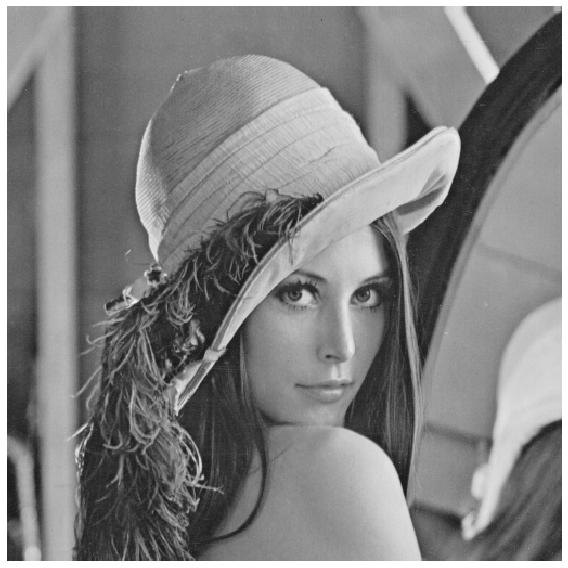

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import jpeg
from plotters import (
    load_image,
    plot_compare,
    plot_image,
    plot_patch,
    plot_pixel_values,
)


image_path = Path('..', 'images', 'lena512.bmp')
im = load_image(image_path)
plot_image(im);

# Image size

We expect the image size to change:
1. when the picture dimensions (shape), i.e. the total number of pixels changes;
2. when the amount of bits per pixel changes.

In case of `2.`, pixels now are in between `0` and `255`, i.e. there are 256 unique possible value. Therefore we need `8` bits per pixel to encode a pixel value.

In [3]:
from operator import mul

image_size = lambda shape, bits_per_pixel=8: mul(*shape) * bits_per_pixel
print(f'We need {image_size(im.shape)} bits to encode this image.')

We need 2097152 bits to encode this image.


# Compression

If the image size is a function of the image (shape) and the bits per pixel, we can reduce the image size by reducing those two factors.

The left image takes 37.5% bits to encode image.


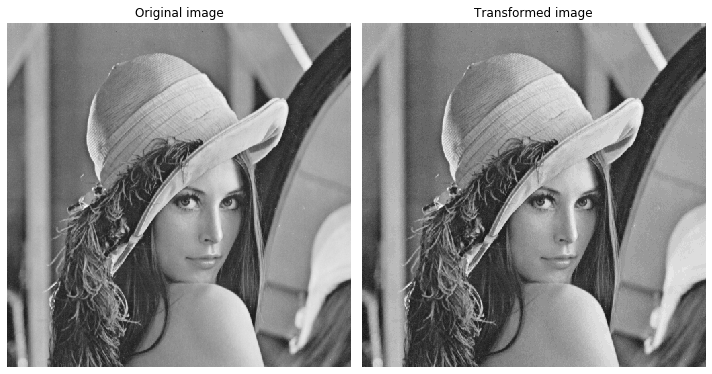

In [40]:
bits_per_pixel = 5
nunique_values = 2 ** bits_per_pixel
im_scaled = ((im / 256) * nunique_values).astype(int)

im_size = image_size(im.shape)
im_scaled_size = image_size(im_scaled.shape, bits_per_pixel)
compression_rate = im_scaled_size / im_size
print(f'The left image takes {(1 - im_scaled_size / im_size) * 100}% bits to encode image.')

plot_compare(im, im_scaled);

The left image takes 75.0% bits to encode image.


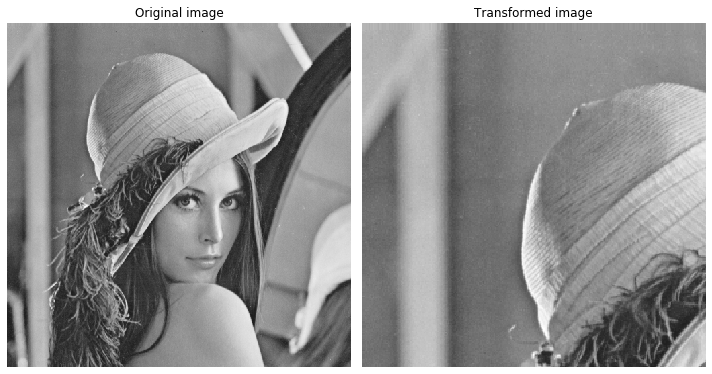

In [5]:
scaled_height = int(im.shape[0] / 2)
scaled_width = int(im.shape[1] / 2)
im_scaled = im[:scaled_height, :scaled_width]

im_scaled_size = image_size(im_scaled.shape)
compression_rate = im_scaled_size / im_size
print(f'The left image takes {(1 - im_scaled_size / im_size) * 100}% bits to encode image.')

plot_compare(im, im_scaled);

# Downsampling

The left image takes 75.0% bits to encode image.


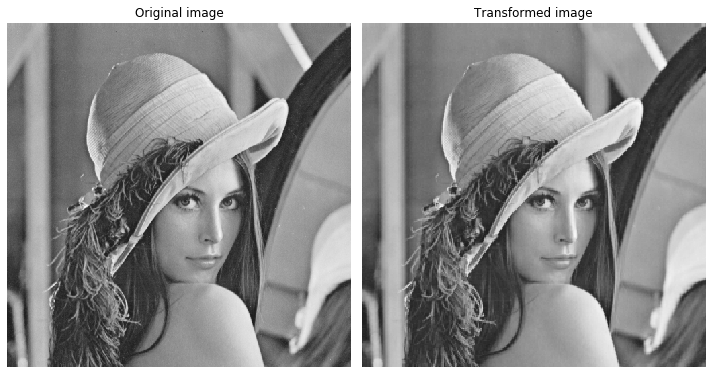

In [6]:
patch_size = 2
downsampled_height = int(im.shape[0] / patch_size)
downsampled_width = int(im.shape[1] / patch_size)

im_downsampled = []

for y in range(0, im.shape[0], patch_size):
    for x in range(0, im.shape[1], patch_size):
        patch = im[y: y + patch_size, x: x + patch_size]
        val = np.mean(patch)
        im_downsampled.append(val)
        
im_downsampled = (
    np.array([im_downsampled])
    .reshape((downsampled_height, downsampled_width))
)

im_downsampled_size = image_size(im_downsampled.shape)
compression_rate = im_downsampled_size / im_size
print(f'The left image takes {(1 - compression_rate) * 100}% bits to encode image.')

plot_compare(im, im_downsampled);

## Try different aggregate methods

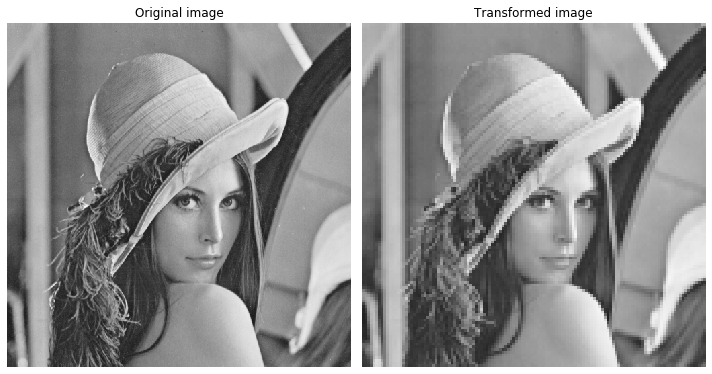

In [7]:
def generate_patches(im, *, patch_size=8):
    for y in range(0, im.shape[0], patch_size):
        for x in range(0, im.shape[1], patch_size):
            patch = im[y: y + patch_size, x: x + patch_size]
            yield patch

            
def downsample(im, func, *, patch_size=8):
    im_downsampled = []
    for patch in generate_patches(im, patch_size=patch_size):
        val = func(patch)
        im_downsampled.append(val)
        
    downsampled_height = int(im.shape[0] / patch_size)
    downsampled_width = int(im.shape[1] / patch_size)
    return (
        np.array([im_downsampled])
        .reshape((downsampled_height, downsampled_width))
    )


im_downsampled = downsample(im, np.mean, patch_size=4)
plot_compare(im, im_downsampled);

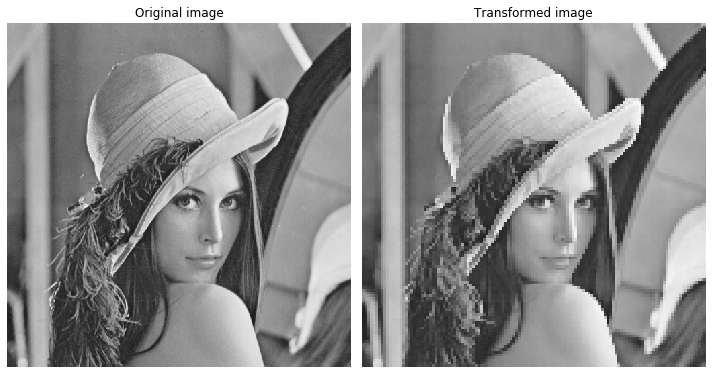

In [8]:
im_downsampled = downsample(im, np.median, patch_size=4)
plot_compare(im, im_downsampled);

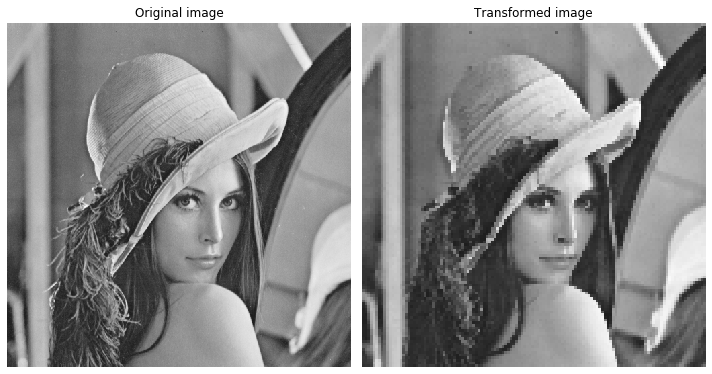

In [9]:
im_downsampled = downsample(im, np.min, patch_size=4)
plot_compare(im, im_downsampled);

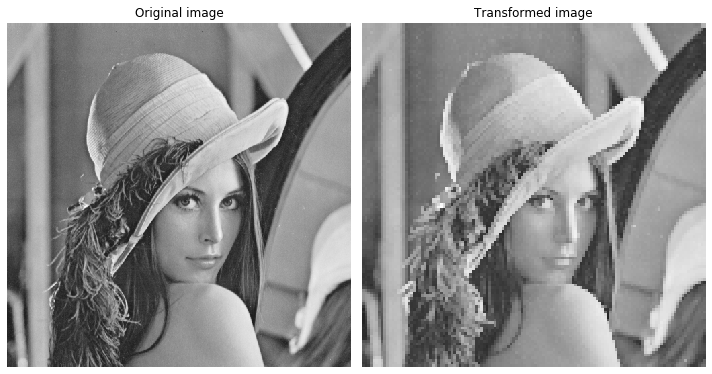

In [10]:
im_downsampled = downsample(im, np.max, patch_size=4)
plot_compare(im, im_downsampled);

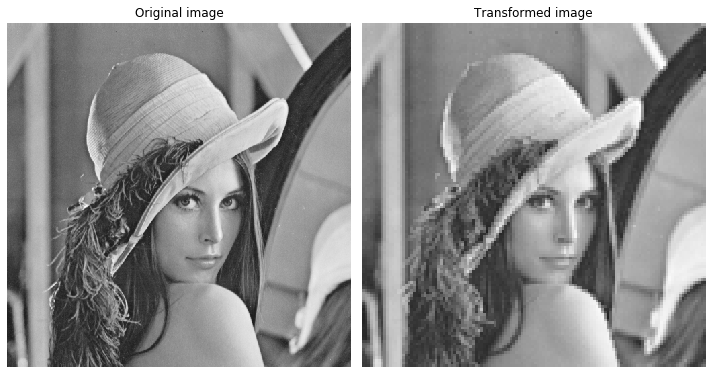

In [11]:
im_downsampled = downsample(
    im, 
    lambda patch: patch.min() + .5 * (patch.max() - patch.min()), 
    patch_size=4
)
plot_compare(im, im_downsampled);

## Why does this work quite well?

In [12]:
import random
patches = list(generate_patches(im))

Max abs diff: 80.0


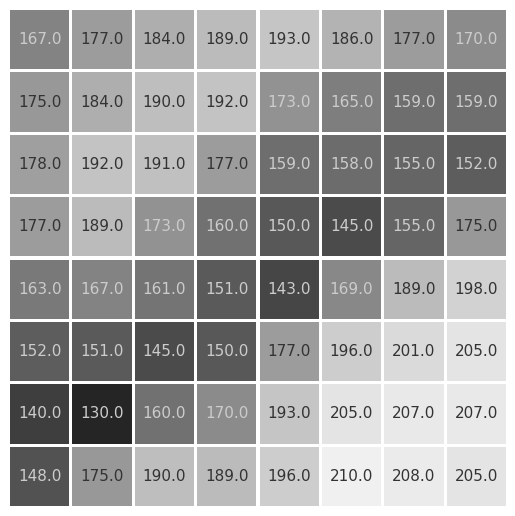

<ggplot: (328037061)>

In [13]:
patch = random.choice(patches)
print(f'Max abs diff: {patch.max() - patch.min()}')
plot_patch(patch)

Patches (of 8 by 8) look quite similar, can we leverage this?

# Filters

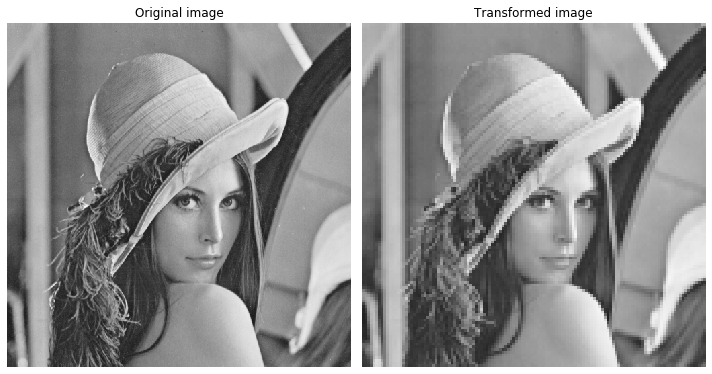

In [14]:
from functools import partial

def apply_filter(patch, filter_):
    if callable(filter_):
        return filter_(patch)
    else:
        return (filter_ * patch).sum()
    
patch_size = 4
mean_filter = np.ones((patch_size, patch_size)) / (patch_size * patch_size)
im_downsampled = downsample(
    im, 
    partial(apply_filter, mean_filter), 
    patch_size=patch_size
)
plot_compare(im, im_downsampled);

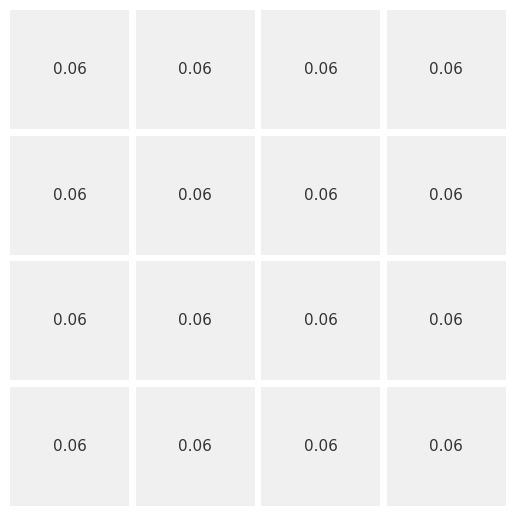

<ggplot: (327945065)>

In [15]:
plot_patch(mean_filter, round_digits=2)

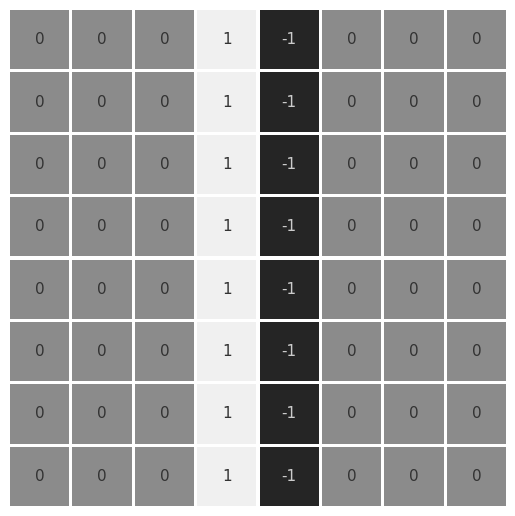

<ggplot: (327789501)>

In [16]:
ver_line_filter = np.array([
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
])


plot_patch(ver_line_filter)

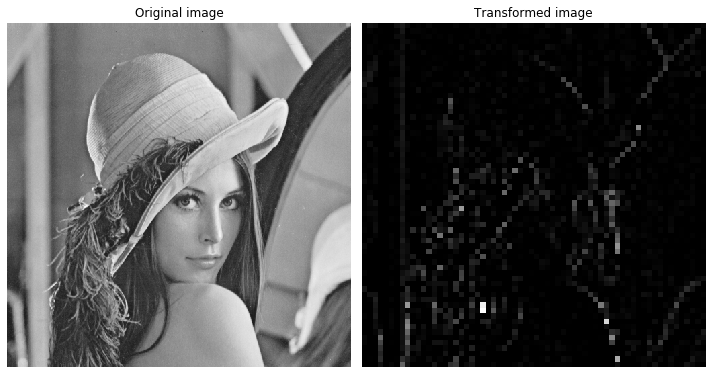

In [17]:
im_downsampled = downsample(
    im, 
    partial(apply_filter, ver_line_filter), 
)
plot_compare(im, im_downsampled);

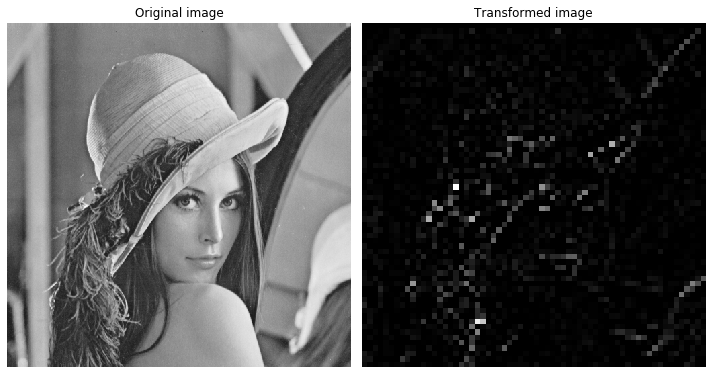

In [18]:
im_downsampled = downsample(
    im, 
    partial(apply_filter, ver_line_filter.T), 
)
plot_compare(im, im_downsampled);

# Can we make filters that look at how much a patch is changing values?

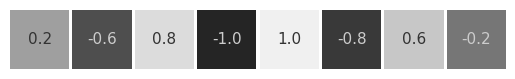

<ggplot: (327733953)>

In [19]:
def discrete_cosine(freq, *, patch_size=8):
    return np.cos(freq * (np.arange(patch_size) + 0.5) * np.pi / patch_size)

dc = discrete_cosine(7)
plot_patch(dc, threshold=0)

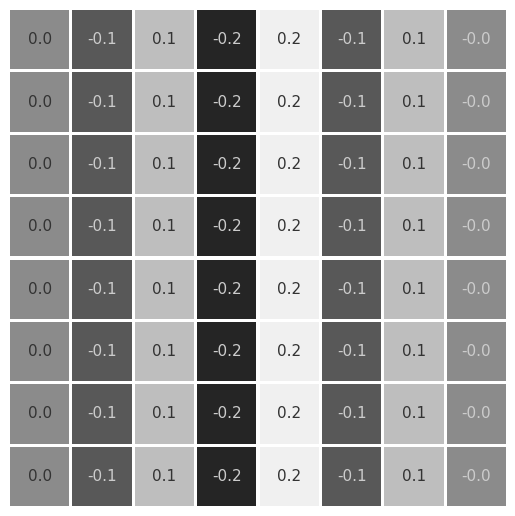

<ggplot: (327720137)>

In [42]:
def normalization_constant(freq):
    return 1 / np.sqrt(2) if freq == 0 else 1


def discrete_cosine_filter(freq_ver, freq_hor):
    dc_ver = discrete_cosine(freq_ver).reshape((-1, 1))
    dc_hor = discrete_cosine(freq_hor).reshape((1, -1))
    c = normalization_constant(freq_ver) * normalization_constant(freq_hor)
    return .25 * c * (dc_ver @ dc_hor)

dc = discrete_cosine_filter(0, 7)
plot_patch(dc, threshold=0)

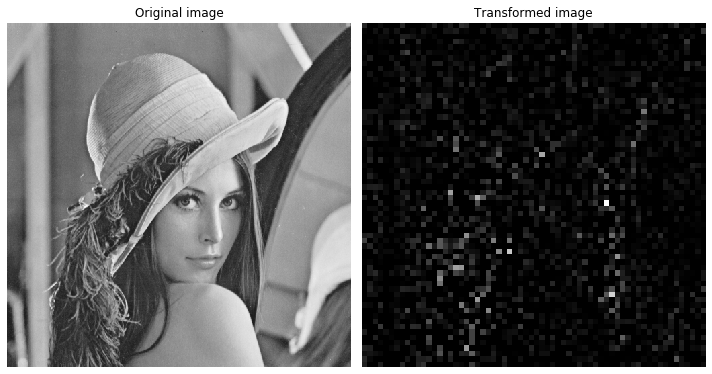

In [41]:
dc = discrete_cosine_filter(0, 7)
im_dc = downsample(im, partial(apply_filter, filter_=dc))
plot_compare(im, im_dc);

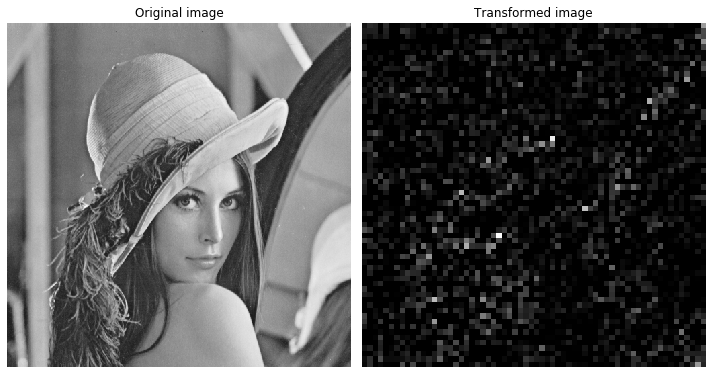

In [22]:
dc = discrete_cosine_filter(7, 0)
im_dc = downsample(im, partial(apply_filter, filter_=dc))
plot_compare(im, im_dc);

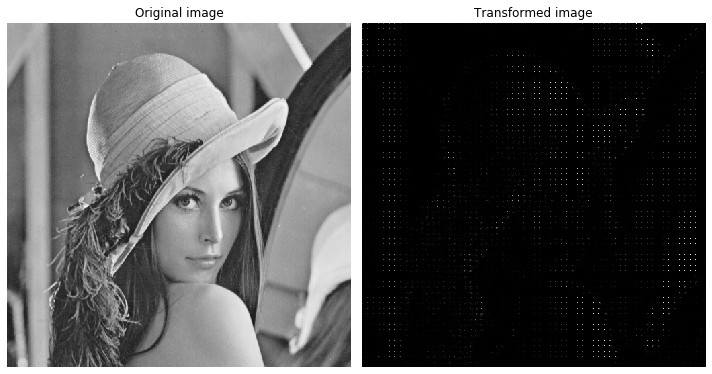

In [23]:
def apply_filters(patch, *filters):
    return np.array([apply_filter(patch, filter_) for filter_ in filters])

def transform(im, filters, *, patch_size=8):
    im_transformed = [
        apply_filters(patch, *filters).reshape(patch_size, patch_size)
        for patch in generate_patches(im, patch_size=patch_size)
    ]
    
    n_hor_patches = int(im.shape[1] / patch_size)
    return np.vstack([
        np.hstack(im_transformed[y * n_hor_patches: (y + 1) * n_hor_patches])
        for y in range(int(im.shape[0] / patch_size))
    ])

def dct(im):
    dc_filters = [
        discrete_cosine_filter(u, v)
        for u in range(8)
        for v in range(8)
    ]

    return transform(im - 128, dc_filters)

im_trans = dct(im)
plot_compare(im, im_trans);

In [24]:
im_trans.min(), im_trans.max()

(-745.7499999999999, 764.9999999999999)

/Users/cor/.virtualenvs/pyjpeg/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 10695'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


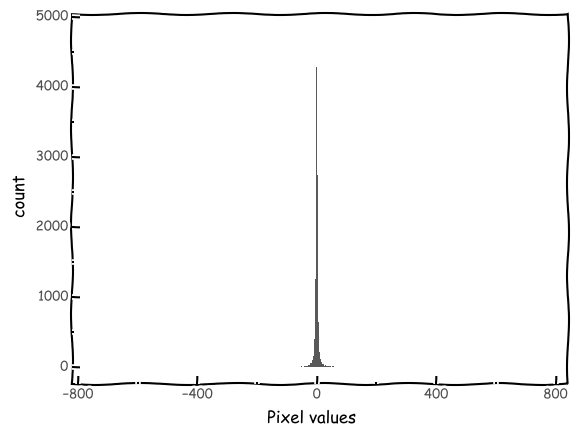

<ggplot: (328201509)>

In [25]:
plot_pixel_values(im_trans)

In [26]:
patches = list(generate_patches(im_trans))

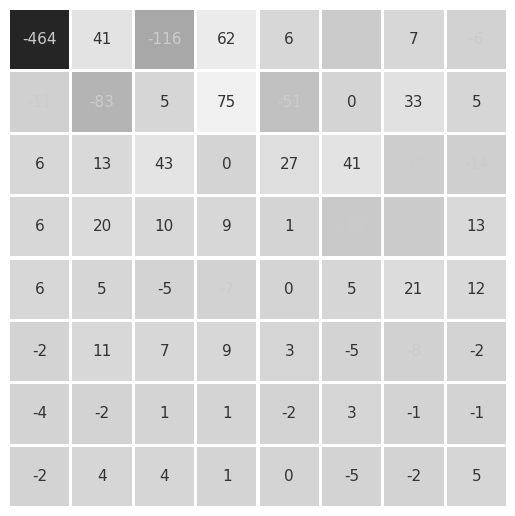

<ggplot: (327892405)>

In [27]:
patch = random.choice(patches)
plot_patch(patch.astype(int))

# Encoding

- 234 - > '11101010'
- 27 -> '00011011'
- ...


All together

```
1110101000011011...
```

In [28]:
from jpeg.utils import (
    int_to_bits,
    bits_to_int,
)

int_to_bits(27).zfill(8)

'00011011'

Use an encoding that use a shorter byte sequence for smaller number and especially for zeros: huffman compression.

1 byte: 
- For example: '10010011'
    1. First half - '1001' - is number of leading zeros.
    2. Second half - '0011' - number of bits after this needed to encode the value.

In [29]:
bits_to_int('1111')

15

In [30]:
def encode(patch):
    leading_zeros = 0
    bit_string = ''
    for val in patch:
        if val == 0:
            leading_zeros += 1
            continue
            
        # 15 leading zeros
        while leading_zeros >= 15:
            bit_string += '1' * 4 + '0' * 4
            leading_zeros -= 15
            
        # Number of leading zeros
        bit_string += int_to_bits(leading_zeros).zfill(4)
        
        val_in_bits = int_to_bits(abs(val))
        # Number of bits needed to encode the value
        bit_string += int_to_bits(len(val_in_bits)).zfill(4)
        
        bit_string += '1' if val < 0 else '0'
        bit_string += val_in_bits
        
        leading_zeros = 0
        
    # End of block
    bit_string += '0' * 8
        
    return bit_string

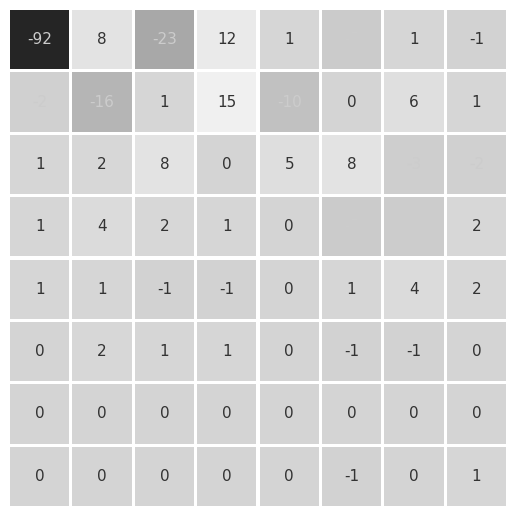

<ggplot: (328496301)>

In [44]:
plot_patch((patch / 5).astype(int))

In [32]:
from jpeg.utils import zigzag_patch
encode(zigzag_patch(patch.astype(int)))

'000010011111010000000001100101001000001001101100000011011000000111110100110000011111110100000001100111110000000110101000001000110100000011011000000011011000000101010100000001100101011000001110100101100000011011000000101111010000001101110011000101000101000000011010100000010110000000111100000001000101100000011110100000100010010000010101101100010011011100000011111000000110010000100000110010100100000001010000001111110000001101110000001011000000010110000000110100000000010100000100010010001010111110100000101110010000000110101000001001111000000101110110000000110101000000100110000000101000000110100000000010100000010110000000111101000001010101010000010001101000001000110000000100110000000001001100010011110100000001110000001011000000001110000001011000000011010100000000'

In [33]:
def compress(im, *, Q=1):
    im_dc = dct(im)
    
    bit_tring = (
        int_to_bits(im.shape[0]).zfill(32) +
        int_to_bits(im.shape[1]).zfill(32)
    )
    
    bit_string = ''.join([
        encode(zigzag_patch((patch / Q).astype(int)))
        for patch in generate_patches(im_dc)
    ])
    
    return bit_string


bit_string = compress(im, Q=5)

In [34]:
im_size = image_size(im.shape)
compression_rate = len(bit_string) / im_size
print(f'The compressed image takes {(1 - compression_rate) * 100}% less bits to encode image.')

The compressed image takes 65.39463996887207% less bits to encode image.


In [35]:
from jpeg import (
    compress,
    decompress
)
from jpeg.quantization import quantization_50 as Q

In [36]:
bit_string = compress(im, Q=Q)

In [37]:
im_size = image_size(im.shape)
compression_rate = len(bit_string) / im_size
print(f'The compressed image takes {(1 - compression_rate) * 100}% less bits to encode image.')

The compressed image takes 88.43441009521484% less bits to encode image.


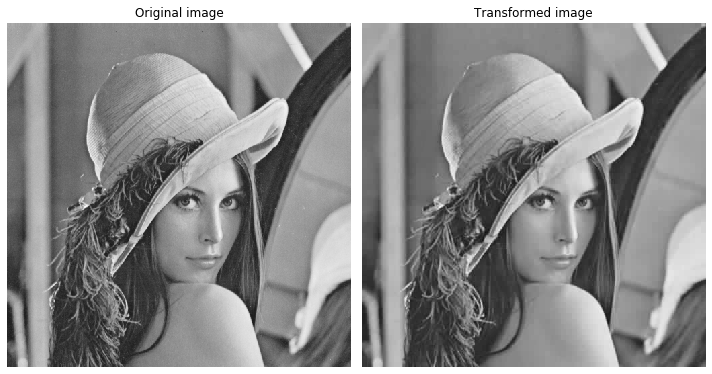

In [38]:
im_back = decompress(bit_string, Q=Q)

plot_compare(im, im_back);